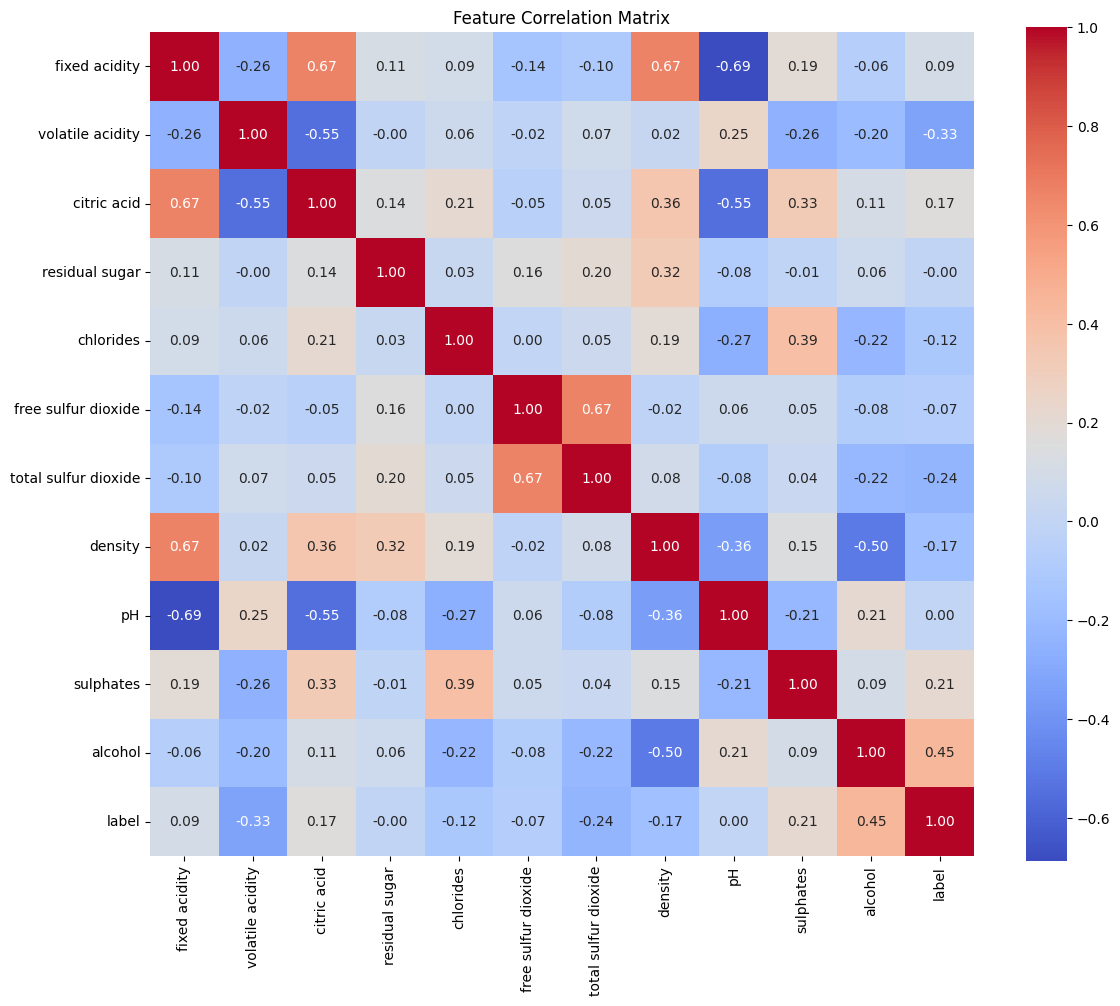

Correlation with label:
 alcohol                 0.446176
volatile acidity       -0.327195
total sulfur dioxide   -0.235046
sulphates               0.211365
density                -0.168958
citric acid             0.167903
chlorides              -0.115071
fixed acidity           0.091761
free sulfur dioxide    -0.069207
pH                      0.004693
residual sugar         -0.002371
Name: label, dtype: float64

Confusion Matrix:
 [[ 97  38]
 [ 33 104]]

Accuracy: 73.9 %

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.73       135
           1       0.73      0.76      0.75       137

    accuracy                           0.74       272
   macro avg       0.74      0.74      0.74       272
weighted avg       0.74      0.74      0.74       272



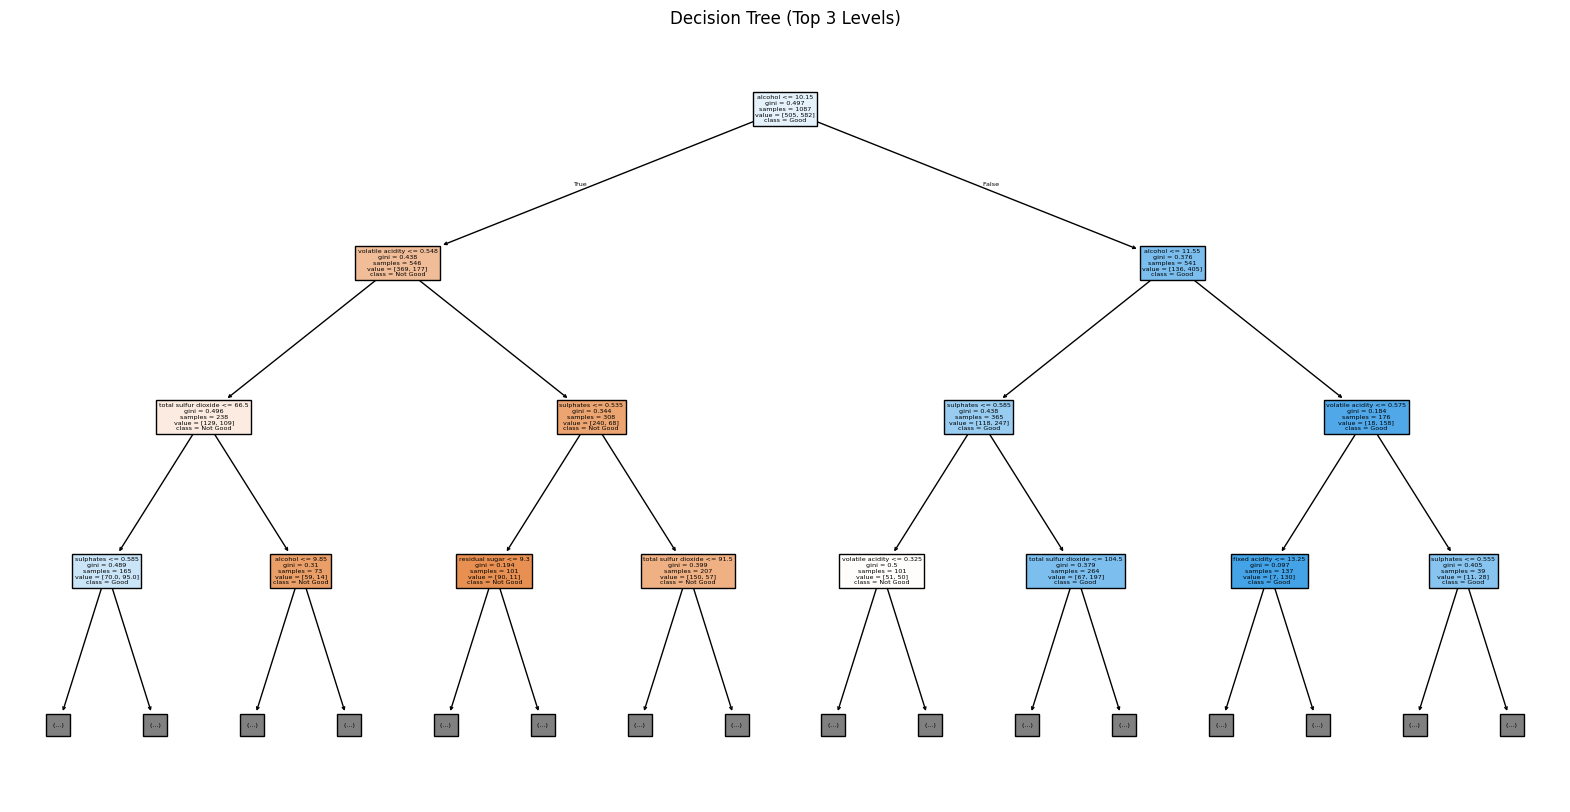

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 2. Load Dataset
df = pd.read_csv("winequality_cleaned.csv")

# 3. Drop 'quality' to prevent data leakage
df = df.drop(columns=['quality'])

# 4. Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

#. Sort correlations with label
label_corr = corr_matrix['label'].drop('label').sort_values(key=abs, ascending=False)
print("Correlation with label:\n", label_corr)

# 6. Train-Test Split
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# 8. Predictions and Evaluation
y_pred = dt.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", round(accuracy * 100, 2), "%")

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

# 9. Plot Top 3 Levels of the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=["Not Good", "Good"], filled=True, max_depth=3)
plt.title("Decision Tree (Top 3 Levels)")
plt.show()

# 10. Save Model
import pickle
pickle.dump(dt, open('decision_tree_model.pkl', 'wb'))

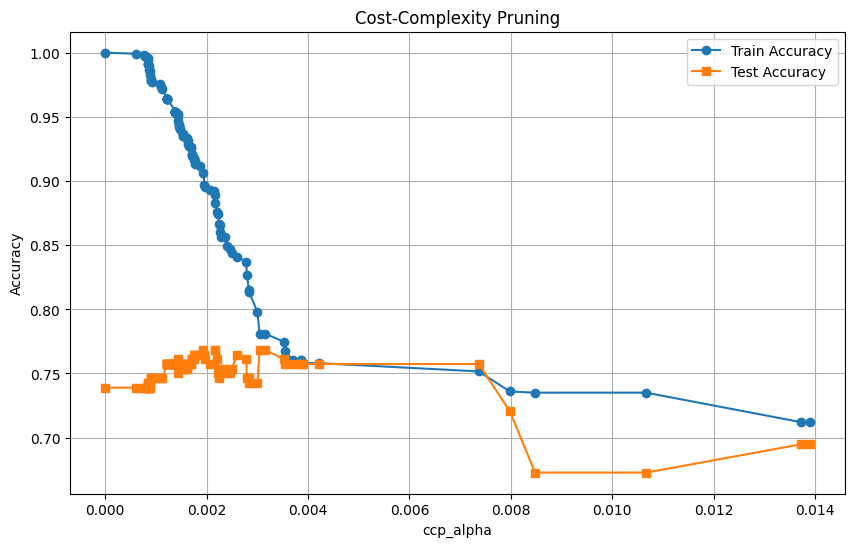

Best alpha: 0.0019375578772228644


DecisionTreeClassifier(ccp_alpha=0.0019375578772228644, random_state=42)

In [2]:
# Step 1: Train unpruned tree and get effective alphas
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas[:-1]  # Exclude the max alpha (which prunes everything)
clfs = []

# Step 2: Train multiple trees for each alpha
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    clfs.append(tree)

# Step 3: Evaluate and plot accuracy vs alpha
train_scores = [tree.score(X_train, y_train) for tree in clfs]
test_scores = [tree.score(X_test, y_test) for tree in clfs]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train Accuracy")
plt.plot(ccp_alphas, test_scores, marker='s', label="Test Accuracy")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Cost-Complexity Pruning")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Pick best alpha (e.g., where test score peaks)
best_idx = np.argmax(test_scores)
best_alpha = ccp_alphas[best_idx]
print("Best alpha:", best_alpha)

# Final model with pruning
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)


Accuracy: 76.84 %

Confusion Matrix:
 [[ 98  37]
 [ 26 111]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       135
           1       0.75      0.81      0.78       137

    accuracy                           0.77       272
   macro avg       0.77      0.77      0.77       272
weighted avg       0.77      0.77      0.77       272



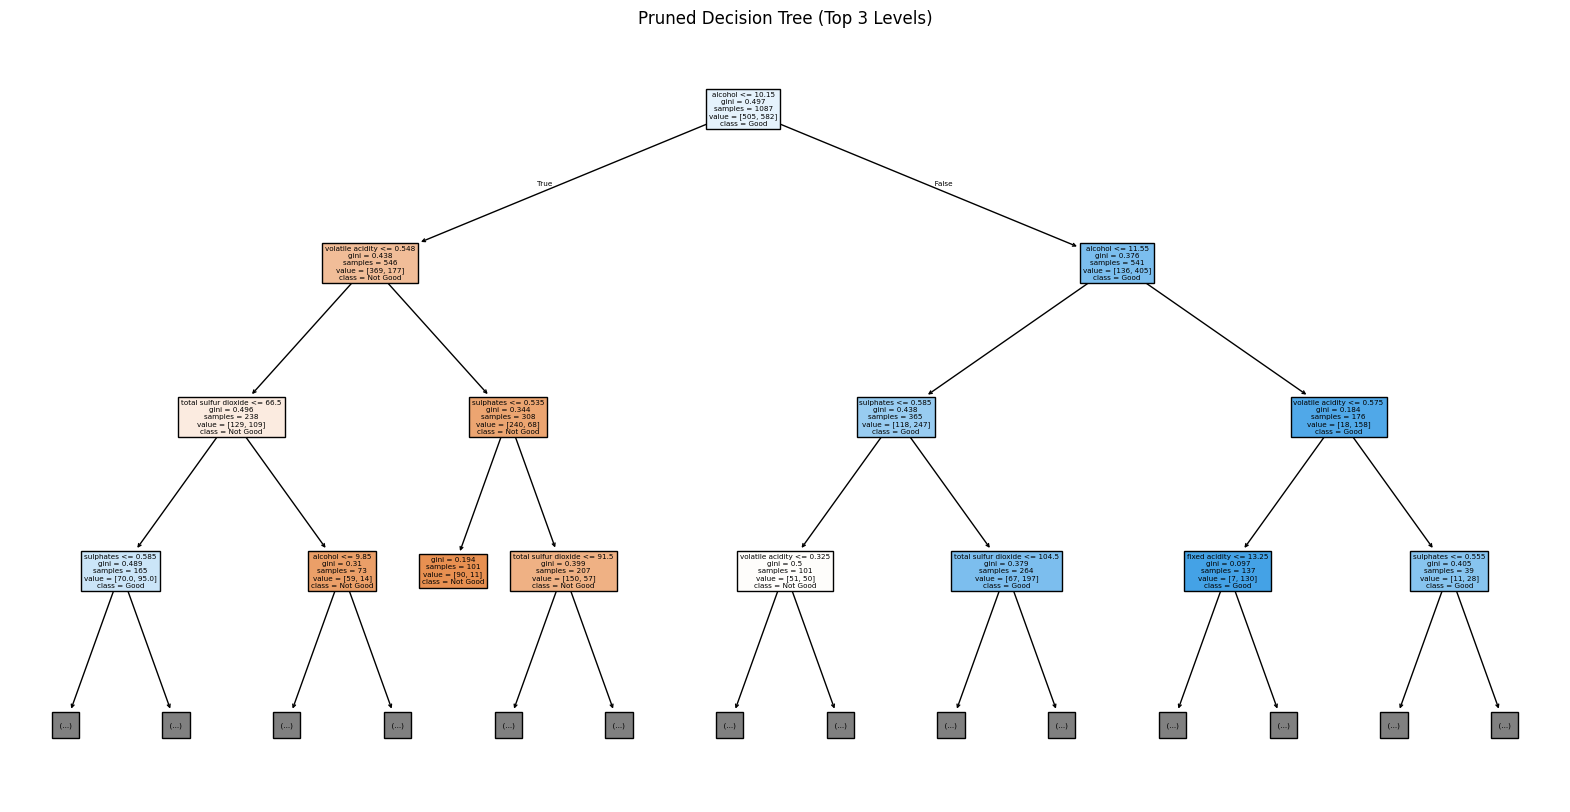

In [3]:
# Train final pruned tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

best_alpha = 0.00194  # from earlier pruning path
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate
y_pred = pruned_tree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize top of pruned tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, class_names=["Not Good", "Good"], filled=True, max_depth=3)
plt.title("Pruned Decision Tree (Top 3 Levels)")
plt.show()
